# **Tabular Reinforcement Learning**

# M2-4 TD learning

## Example of the SARSA algorithm

Below we will see a simple example that will allow us to understand the concepts introduced in this section.  

First we will install the [Gymnasium](https://gymnasium.farama.org/) library (if we do not have it installed):

> !pip install gymnasium

For backward compatibility with code created for OpenAI Gym.

## The CliffWalking environment

The CliffWalking environment consists of an agent that moves on a grid of dimensions 12x4 (width x height). 
- In each step, the agent has 4 options for action or movement: UP, DOWN, RIGHT, LEFT. 
- The agent always starts from the same square [0, 3] (lower left corner) and the game ends when the agent reaches the arrival square [11, 3] (lower right corner). 
- The position of each box is given by a pair of natural numbers [x, y], where the position of the top left corner would be the origin of coordinates [0, 0].
- Immediate reward is R=-1 for all the boxes, except in the boxes that connect the departure box to the arrival box in a straight line (boxes [1, 3] to [10, 3]). In these boxes, which simulate a **cliff**, the reward is R=-100 and you return to the initial box.

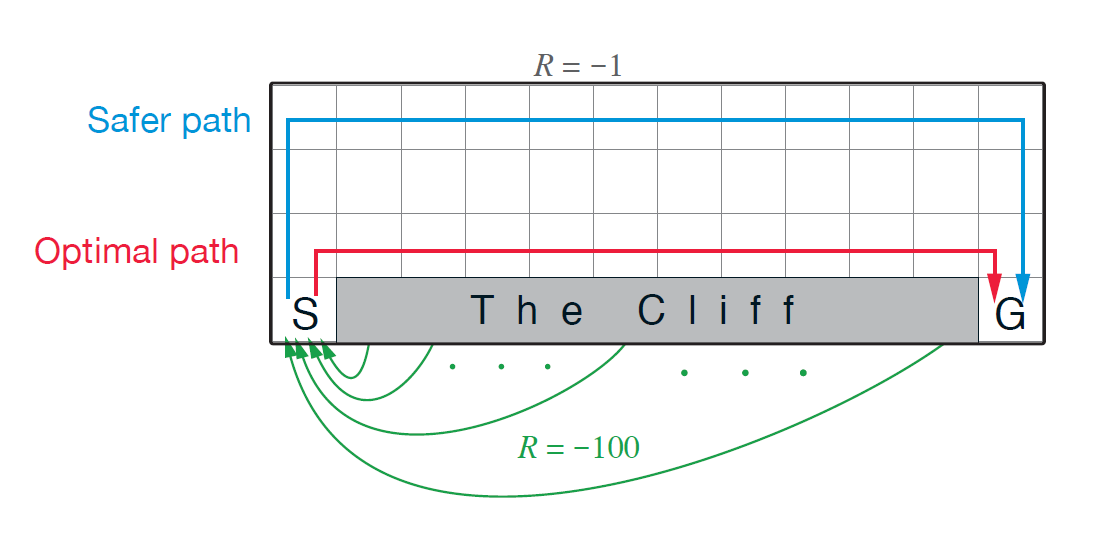

he code to implement this environment, which is available in the attached file `cliff_env.py`, has been adapted from the following link: 
- https://pypi.org/project/gym-gridworlds/

### 1. Data load

The following code loads the packages necessary to run the example, creates the environment by instantiating an object of the `CliffEnv` class (imported from the attached file `cliff_env.py`), and prints the dimension of the action space:
- 0 = up, 
- 1 = right, 
- 2 = down,
- and 3 = left

The space of observations is a **tuple** indicating the **position of the agent** in the grid, and the **range of the reward** variable (whose value is -1 or -100 depending on the cell visited and which therefore goes from less infinity to more infinity).

In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np


class CliffEnv(gym.Env):
    def __init__(self, width=12, height=4):
        self.width = width
        self.height = height
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Tuple((
                spaces.Discrete(self.width),
                spaces.Discrete(self.height)
                ))
        self.moves = {
                0: (0, -1),   # up
                1: (1, 0),   # right
                2: (0, 1),  # down
                3: (-1, 0),  # left
                }

        # begin in start state
        self.reset()

    def step(self, action):
        x, y = self.moves[action]
        self.S = self.S[0] + x, self.S[1] + y

        self.S = max(0, self.S[0]), max(0, self.S[1])
        self.S = (min(self.S[0], self.width - 1),
                  min(self.S[1], self.height - 1))

        if self.S == (self.width - 1, self.height - 1):
            # get Goal state
            return self.S, 0, True, {}
        elif self.S[0] != 0 and self.S[1] == self.height - 1:
            # the cliff
            # get -100 reward
            return self.reset(), -100, False, {}
        else:
            # anything else
            return self.S, -1, False, {}

    def reset(self):
        self.S = (0, self.height-1)
        return self.S

In [2]:
# Params
width = 12
height = 4

env = CliffEnv(width, height)

print("Action space is     : {} ".format(env.action_space))
print("Observation space is: {} ".format(env.observation_space))

Action space is     : Discrete(4) 
Observation space is: Tuple(Discrete(12), Discrete(4)) 


### 2. Running a random episode

Next, we will execute an episode of the _CliffWalking environment_ using an agent that selects actions randomly.

In [3]:
# Environment reset
obs = env.reset()
t, total_reward, done = 0, 0, False

print("Obs inicial: {} ".format(obs))

switch_action = {
        0: "U",
        1: "R",
        2: "D",
        3: "L",
    }

while not done:
    # Elegir una acción aleatoria (ésta es la implementación del agente)
    action = env.action_space.sample()
    
    # Ejecutar la acción y esperar la respuesta del entorno
    new_obs, reward, done, info = env.step(action)
    
    # Imprimir time-step
    #print("Action: {} -> Obs: {} and reward: {}".format(switch_action[action], new_obs, reward))
    
    # Actualizar variables
    obs = new_obs
    total_reward += reward
    t += 1
    
print("Episode finished after {} timesteps and reward was {} ".format(t, total_reward))
env.close()

Obs inicial: (0, 3) 
Episode finished after 2481 timesteps and reward was -26438 


## 3. TD learning

Given that the environment is deterministic, it is feasible to find an optimal policy (which in this case is unique) that achieves the highest return (and therefore the shortest path).

The objective of this section is to estimate the **optimal policy** using **TD learing** methods, specifically we will study the **SARSA** algorithm.

Implement the *SARSA* algorithm explained in the "Temporal Difference Learning" module using the following parameters:

- Number pf episodes = 1000
- *learning rate* = 0.5
- *discount factor* = 1
- *epsilon* = 0.05  

In [4]:
import matplotlib.pyplot as plt
import matplotlib.collections as mcol
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.lines import Line2D
from collections import defaultdict

env = CliffEnv(width, height)

print("Action space is {} ".format(env.action_space))
print("Observation space is {} ".format(env.observation_space))

Action space is Discrete(4) 
Observation space is Tuple(Discrete(12), Discrete(4)) 


In [5]:
def epsilon_greedy_policy(Q, state, nA, epsilon):
    '''
    Create a policy where epsilon dictates the probability of a random action being carried out.

    :param Q: linka state -> action value (dictionary)
    :param state: state in which the agent is (int)
    :param nA: number of actions (int)
    :param epsilon: possibility of random movement (float)
    :return: probability of each action (list) d
    '''
    probs = np.ones(nA) * epsilon / nA
    best_action = np.argmax(Q[state])
    probs[best_action] += 1.0 - epsilon

    return probs

In [6]:
def SARSA(episodes, learning_rate, discount, epsilon):
    '''
    Learn to solve the environment using the SARSA algorithm

    :param episodes: Number of episodes (int)
    :param learning_rate: Learning rate (float [0, 1])
    :param discount: Discount factor (float [0, 1])
    :param epsilon: chance that random movement is required (float [0, 1])
    :return: x,y number of episodes and number of steps
    :Q: action value function
    '''

    # Link actions to states
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Number of episodes
    x = np.arange(episodes)
    y = np.zeros(episodes)
    
    for episode in range(episodes):
        state = env.reset()
        # Select and execute an action
        probs = epsilon_greedy_policy(Q, state, env.action_space.n, epsilon)
        action = np.random.choice(np.arange(len(probs)), p=probs)
        
        done = False
        step = 1
                
        while not done:
            # Execute action
            next_state, reward, done, _ = env.step(action)
            
            # Select and execute action
            probs = epsilon_greedy_policy(Q, next_state, env.action_space.n, epsilon)
            next_action = np.random.choice(np.arange(len(probs)), p=probs)
           
            # Update TD
            td_target = reward + discount * Q[next_state][next_action]
            td_error = td_target - Q[state][action]
            Q[state][action] += learning_rate * td_error
                        
            if done:
                y[episode] = step
                break

            state = next_state
            action = next_action
            step += 1
                 
    return x, y, Q

In [7]:
x, y, q = SARSA(episodes=1000, learning_rate=0.5, discount=1, epsilon=0.05)

Display the **estimated Q values** for each state-action pair on the screen.

In [8]:
# show the Q of each state-action and the value function
for i in range(width):
    for j in range(height):
        V = max(q[i,j])
        A = np.argmax(q[i,j])
        print((i,j), q[i,j], V, A)

(0, 0) [-17.59793356 -13.89084285 -18.25955697 -16.60478486] -13.890842852495634 1
(0, 1) [-15.09320399 -16.69241713 -19.97554917 -18.11634579] -15.093203993089244 0
(0, 2) [-16.24438442 -35.07690804 -23.67675197 -21.46770488] -16.244384424440184 0
(0, 3) [ -17.31844528 -143.47380077  -25.1870097   -34.96236076] -17.31844527549608 0
(1, 0) [-16.14890308 -12.7399253  -16.05984298 -17.5867117 ] -12.739925297321783 1
(1, 1) [-14.22577649 -25.84076558 -18.61400262 -18.6538987 ] -14.22577648771238 0
(1, 2) [ -16.52357271  -23.80982494 -102.60919118  -19.14174657] -16.52357270530419 0
(1, 3) [0. 0. 0. 0.] 0.0 0
(2, 0) [-14.90145641 -11.63310162 -15.68293468 -16.85111312] -11.633101617435248 1
(2, 1) [-17.37612845 -13.79666533 -35.86901195 -18.51819964] -13.796665332692971 1
(2, 2) [ -14.22099865  -14.60954559 -108.49184604  -16.50926171] -14.220998654698326 0
(2, 3) [0. 0. 0. 0.] 0.0 0
(3, 0) [-12.83409659 -10.54228691 -13.70057936 -16.30539938] -10.542286911949017 1
(3, 1) [-14.11964973 -12

Display on the screen the values of the **value function $v_\pi(s)$** estimated for each state.

In [9]:
# function that displays the values of the state function V(s) on the grid
def print_values_SARSA(Q, width, height):
    for j in range(height):
        print("-----------------------------------------------------------------------------")
        for i in range(width):
            arr = np.array(Q[i,j])
            v = np.amax(arr)
            q = abs(v)
            print("{:4f}|".format(v), end="")
        print("")
    print("-----------------------------------------------------------------------------")

In [10]:
print_values_SARSA(q, width, height)

-----------------------------------------------------------------------------
-13.890843|-12.739925|-11.633102|-10.542287|-9.548035|-8.737646|-7.990243|-6.999658|-6.743618|-4.108515|-3.905612|-2.099337|
-----------------------------------------------------------------------------
-15.093204|-14.225776|-13.796665|-12.203105|-10.811442|-12.357363|-6.907218|-5.675865|-4.285338|-3.067368|-2.006693|-1.000001|
-----------------------------------------------------------------------------
-16.244384|-16.523573|-14.220999|-16.207226|-14.489796|-15.704418|-8.073786|-7.100510|-6.203204|-4.459235|-3.063497|0.000000|
-----------------------------------------------------------------------------
-17.318445|0.000000|0.000000|0.000000|0.000000|0.000000|0.000000|0.000000|0.000000|0.000000|0.000000|0.000000|
-----------------------------------------------------------------------------


Implement a function that prints on the screen the **optimal policy** found for each cell.

In [11]:
def print_policy_SARSA(Q, width, height):
    switch_action = {
        0: "U",
        1: "R",
        2: "D",
        3: "L"
    }
    for j in range(height):
        print("------------------------------------------------------------------------")
        for i in range(width):
            arr = np.array(Q[i,j])
            act = np.argmax(arr)
            a = switch_action[act]
            print("  %s  |" % a, end="")
        print("")
        
    print("------------------------------------------------------------------------")

In [12]:
print_policy_SARSA(q, width, height)

------------------------------------------------------------------------
  R  |  R  |  R  |  R  |  R  |  R  |  R  |  D  |  D  |  D  |  D  |  D  |
------------------------------------------------------------------------
  U  |  U  |  R  |  R  |  U  |  L  |  R  |  R  |  R  |  R  |  R  |  D  |
------------------------------------------------------------------------
  U  |  U  |  U  |  U  |  U  |  U  |  U  |  U  |  R  |  U  |  U  |  D  |
------------------------------------------------------------------------
  U  |  U  |  U  |  U  |  U  |  U  |  U  |  U  |  U  |  U  |  U  |  U  |
------------------------------------------------------------------------


**Execute an episode following the optimal policy** found, where the trajectory followed by the agent can be recognized.

In [13]:
# execution of an episode following the optimal policy
def execute_episode_SARSA(q, env):
    obs = env.reset()
    t, total_reward, done = 0, 0, False

    print("Obs initial: {} ".format(obs))

    switch_action = {
            0: "U",
            1: "R",
            2: "D",
            3: "L",
        }

    for t in range(1000): # We limit the number of time-steps in each episode to 1000
        
        # Choose a stock following the optimal policy
        arr = np.array(q[obs])
        action = arr.argmax()
       
        # Execute the action and wait for the response from the environment
        new_obs, reward, done, info = env.step(action)
        obs = new_obs
        print("Action: {} -> Obs: {} and reward: {}".format(switch_action[action], obs, reward))

        if t==999:
            print("Number of time-septs exceeds 1000. STOP episode.") 
        total_reward += reward
        t += 1
        if done:
            break
   
    print("Episode finished after {} timesteps and reward was {} ".format(t, total_reward))
    env.close()

In [14]:
execute_episode_SARSA(q, env)

Obs initial: (0, 3) 
Action: U -> Obs: (0, 2) and reward: -1
Action: U -> Obs: (0, 1) and reward: -1
Action: U -> Obs: (0, 0) and reward: -1
Action: R -> Obs: (1, 0) and reward: -1
Action: R -> Obs: (2, 0) and reward: -1
Action: R -> Obs: (3, 0) and reward: -1
Action: R -> Obs: (4, 0) and reward: -1
Action: R -> Obs: (5, 0) and reward: -1
Action: R -> Obs: (6, 0) and reward: -1
Action: R -> Obs: (7, 0) and reward: -1
Action: D -> Obs: (7, 1) and reward: -1
Action: R -> Obs: (8, 1) and reward: -1
Action: R -> Obs: (9, 1) and reward: -1
Action: R -> Obs: (10, 1) and reward: -1
Action: R -> Obs: (11, 1) and reward: -1
Action: D -> Obs: (11, 2) and reward: -1
Action: D -> Obs: (11, 3) and reward: 0
Episode finished after 17 timesteps and reward was -16 
